<a href="https://colab.research.google.com/github/YunoGr/google-colab-prototypes/blob/main/notebooks/StatisticalDownscaling_PrecipitationSenegal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Downscaling of Precipitation with U-Net

Author: **Pape Malick DIOP**

Affiliation: *Iba Der Thiam University of Thies, SENEGAL*  
Date: November 27, 2025

[GitHub Repository](https://github.com/YunoGr/google-colab-prototypes/tree/main/notebooks)

[Drive Repository](https://drive.google.com/file/d/1_ENWbu_bfWaXJEfFuvuipVxGf3HYsiDX/view?usp=drive_link)

### **Project Context**

This notebook presents a statistical downscaling approach using a U-Net convolutional neural network
to map low-resolution climate data to high-resolution fields over Senegal.


The work is based on a hands-on project conducted during the *AI4Climate and Weather Forecast Training School*,
with personal analysis, interpretation, and discussion.

We will train a Convolutional Neural Network (U-Net) to map:
$$ X_{\text{coarse}} \rightarrow Y_{\text{fine}} $$



**Dataset**: We will use IMERG Precipitation data over Senegal (Hourly, JJASO months) which is around 88K samples

## Environment Setup and Libraries

We first install and import the required Python libraries used throughout
the experiment.

In [1]:
# Install Cartopy and its dependencies
!pip install --no-binary shapely shapely --force
!pip install cartopy

# from google.colab import drive
# drive.mount('/content/drive')

  Using cached shapely-2.1.2-cp312-cp312-linux_x86_64.whl
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.2
    Uninstalling shapely-2.1.2:
      Successfully uninstalled shapely-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26

In [2]:
# Load required libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Data Download

The datasets used in this experiment are downloaded from remote servers.
They include low-resolution climate inputs and corresponding high-resolution
reference data over Senegal.

This step ensures reproducibility of the experiment.

In [4]:
# Download Data from Zenodo
ZENODO_URL = "https://zenodo.org/records/17651976/files/IMERG_Senegal_1h_JJASO.npz"
DATA_DIR = "data"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

precip_path = os.path.join(DATA_DIR, 'IMERG_Senegal_1h_JJASO.npz')

print(f"Downloading data to {precip_path}...")
# We use wget to download.
!wget {ZENODO_URL} -O {precip_path}

--2025-12-15 23:53:22--  https://zenodo.org/records/17651976/files/IMERG_Senegal_1h_JJASO.npz
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443890402 (1.3G) [application/octet-stream]
Saving to: ‘data/IMERG_Senegal_1h_JJASO.npz’

data/IMERG_Senegal_ 100%[===================>]   1.34G  17.9MB/s    in 79s     

2025-12-15 23:54:42 (17.4 MB/s) - ‘data/IMERG_Senegal_1h_JJASO.npz’ saved [1443890402/1443890402]



In this section, the downloaded datasets are loaded into memory.
We inspect their structure, dimensions, and variables to understand
the spatial resolution and temporal coverage.

In [5]:
# Load data
precip_path = 'data/IMERG_Senegal_1h_JJASO.npz'
precip_npz = np.load(precip_path)
precip_all = precip_npz['data']  # Shape: (Time, Height, Width)
lon_fine = precip_npz['lon'] # Shape: (64,)
lat_fine = precip_npz['lat'] # Shape: (64,)

print(f"Original Data Shape: {precip_all.shape}")
print(f"Coords Shape: {lon_fine.shape}, {lat_fine.shape}")

Original Data Shape: (88128, 64, 64)
Coords Shape: (64,), (64,)


In [6]:
# Create Coarse Data (The Inverse Problem)
# 1. Reshape to (Time, 16, 4, 16, 4)
# 2. Average over the 4x4 blocks
precip_coarse = precip_all.reshape(
    precip_all.shape[0],
    16, 4,
    16, 4
).mean(axis=(2, 4))

# Create Coarse Coords (Average every 4 points)
lon_coarse = lon_fine.reshape(16, 4).mean(axis=1)
lat_coarse = lat_fine.reshape(16, 4).mean(axis=1)

print(f"Coarse Data Shape: {precip_coarse.shape}")
print(f"Coarse Coords Shape: {lon_coarse.shape}, {lat_coarse.shape}")

Coarse Data Shape: (88128, 16, 16)
Coarse Coords Shape: (16,), (16,)


## Visualization of Low- and High-Resolution Fields

Visual inspection helps understand the scale mismatch between
low-resolution inputs and high-resolution targets, which motivates
the use of downscaling techniques.

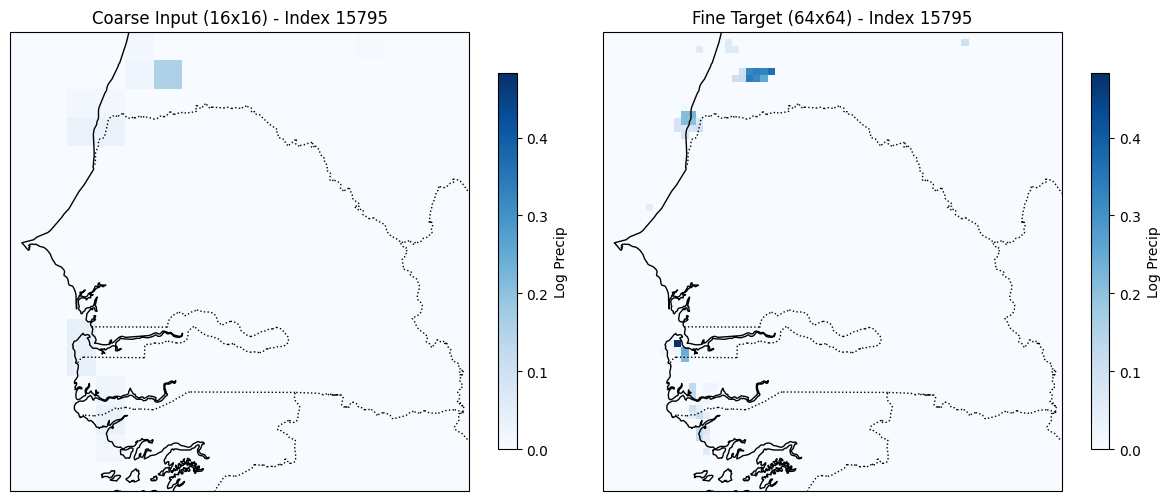

In [7]:
def plot_example(coarse_data, fine_data, lon_c, lat_c, lon_f, lat_f, idx=None):
    if idx is None:
        idx = np.random.randint(0, coarse_data.shape[0])

    fig = plt.figure(figsize=(12, 5))

    # Compute common vmin/vmax for fair comparison
    data_min = min(np.log1p(coarse_data[idx]).min(), np.log1p(fine_data[idx]).min())
    data_max = max(np.log1p(coarse_data[idx]).max(), np.log1p(fine_data[idx]).max())

    # Coarse
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_title(f"Coarse Input (16x16) - Index {idx}")
    # pcolormesh needs 2D coords or 1D coords matching dimensions.
    # Our lon_c/lat_c are 1D, so we can pass them directly.
    im1 = ax1.pcolormesh(lon_c, lat_c, np.log1p(coarse_data[idx]), cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=data_min, vmax=data_max)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im1, ax=ax1, label='Log Precip', orientation='vertical', shrink=0.8)

    # Fine
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_title(f"Fine Target (64x64) - Index {idx}")
    im2 = ax2.pcolormesh(lon_f, lat_f, np.log1p(fine_data[idx]), cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=data_min, vmax=data_max)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im2, ax=ax2, label='Log Precip', orientation='vertical', shrink=0.8)

    plt.tight_layout()
    plt.show()

# Show a random example
plot_example(precip_coarse, precip_all, lon_coarse, lat_coarse, lon_fine, lat_fine)

## Data Preprocessing
1.  **Split**: Train (2001-2020), Validation (2021-2022), Test (2023-2024), but reminder it's only JJASO months
2.  **Normalization**: We use `log1p` (log(1+x)) to handle the heavy-tailed distribution of precipitation.
3.  **Thresholding**: We set very small values (< 0.1 mm) to 0.


In [8]:
# Configuration
WET_THRESHOLD = 0.1
BATCH_SIZE = 32

# Split
n_total = precip_all.shape[0]
n_holdout = int(n_total * (1/6)) # Approx last 4 years
mid_holdout = n_holdout // 2

# Indices
idx_train_end = n_total - n_holdout
idx_val_end = n_total - mid_holdout

# Raw Split
Y_train_raw = precip_all[:idx_train_end]
X_train_raw = precip_coarse[:idx_train_end]

Y_val_raw = precip_all[idx_train_end:idx_val_end]
X_val_raw = precip_coarse[idx_train_end:idx_val_end]

Y_test_raw = precip_all[idx_val_end:]
X_test_raw = precip_coarse[idx_val_end:]

In [9]:
print(f"Train: {X_train_raw.shape[0]} samples")
print(f"Val  : {X_val_raw.shape[0]} samples")
print(f"Test : {X_test_raw.shape[0]} samples")

Train: 73440 samples
Val  : 7344 samples
Test : 7344 samples


In [10]:
# Preprocessing Function
def preprocess(X, Y, threshold=0.1):
    # Thresholding
    X[X < threshold] = 0
    Y[Y < threshold] = 0

    # Log Transform
    X_log = np.log1p(X)
    Y_log = np.log1p(Y)

    # Add Channel Dimension (N, H, W) -> (N, 1, H, W)
    X_log = X_log[:, None, :, :]
    Y_log = Y_log[:, None, :, :]

    return X_log, Y_log

# Apply Preprocessing
X_train, Y_train = preprocess(X_train_raw, Y_train_raw, WET_THRESHOLD)
X_val, Y_val = preprocess(X_val_raw, Y_val_raw, WET_THRESHOLD)
X_test, Y_test = preprocess(X_test_raw, Y_test_raw, WET_THRESHOLD)

# Clean up raw data to save memory
del precip_all, precip_coarse, X_train_raw, Y_train_raw, X_val_raw, Y_val_raw, X_test_raw, Y_test_raw

## U-Net Model Architecture

The U-Net architecture is used to learn spatial mappings between
low- and high-resolution climate fields. Its encoder–decoder structure
with skip connections allows the model to capture both large-scale
patterns and fine-scale details.

- **Encoder**: Downsamples the image, capturing context.
- **Decoder**: Upsamples the features, localizing the output.
- **Skip Connections**: Preserve spatial information lost during downsampling.

We define a flexible `UnetPr` class.

In [11]:
class UnitConv(nn.Module):
    """
    Basic Convolution Block: Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, batch_norm=True):
        super().__init__()
        layers = []
        # First Conv
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=not batch_norm))
        if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        # Second Conv
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, bias=not batch_norm))
        if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UpLayer(nn.Module):
    """
    Upsampling Block: Transposed Conv or Bilinear Upsample + Conv
    """
    def __init__(self, in_channels, out_channels, trans_conv=True):
        super().__init__()
        if trans_conv:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            )

    def forward(self, x):
        return self.up(x)

class UnetPr(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base=32, batch_norm=True):
        super().__init__()

        # Encoder
        self.enc1 = UnitConv(in_channels, base, batch_norm=batch_norm)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = UnitConv(base, base*2, batch_norm=batch_norm)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = UnitConv(base*2, base*4, batch_norm=batch_norm)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = UnitConv(base*4, base*8, batch_norm=batch_norm)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.center = UnitConv(base*8, base*16, batch_norm=batch_norm)

        # Decoder
        self.dec4 = UpLayer(base*16, base*8)
        self.conv4 = UnitConv(base*16, base*8, batch_norm=batch_norm) # 8 from up + 8 from skip

        self.dec3 = UpLayer(base*8, base*4)
        self.conv3 = UnitConv(base*8, base*4, batch_norm=batch_norm)

        self.dec2 = UpLayer(base*4, base*2)
        self.conv2 = UnitConv(base*4, base*2, batch_norm=batch_norm)

        self.dec1 = UpLayer(base*2, base)
        self.conv1 = UnitConv(base*2, base, batch_norm=batch_norm)

        # Final Upsample to 64x64 (Super-resolution step)
        # Input is 16x16. We need 2 upsamples to get to 64x64.
        self.final_up1 = UpLayer(base, base)
        self.final_up2 = UpLayer(base, base)
        self.final_conv = nn.Conv2d(base, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        c = self.center(p4)

        # Decoder
        d4 = self.dec4(c)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.conv4(d4)

        d3 = self.dec3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.conv3(d3)

        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.conv2(d2)

        d1 = self.dec1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.conv1(d1)

        # Final Upsample to 64x64
        out = self.final_up1(d1) # 16 -> 32
        out = self.final_up2(out) # 32 -> 64
        out = self.final_conv(out)

        return out

## Model Training

The model is trained using a supervised learning approach.

We define the DataLoaders, Loss Function, and Optimizer.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Datasets
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

### Loss function
The training objective is based on the L1 loss, defined as:
$$
\mathcal{L}_{\text{L1}}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
$$

The L1 loss penalizes errors linearly and is more robust to outliers
than the mean squared error, which can help preserve sharp spatial structures.

### Optimizer

The model is trained using the AdamW optimizer, whose update rule is:
$$
\theta_{t+1} = \theta_t
- \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
- \eta \lambda \theta_t
$$

AdamW improves generalization by decoupling weight decay from gradient-based updates,
which is particularly beneficial for deep neural networks.


In [14]:
# Model Init
model = UnetPr(in_channels=1, out_channels=1, base=32).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.L1Loss()

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Parameters: 7,770,721


In [15]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

In [16]:
# Training
EPOCHS = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_unet.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.4f} - Val: {val_loss:.4f} (New Best!)")
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.4f} - Val: {val_loss:.4f}")

Starting training...
Epoch 1/20 - Train: 0.0288 - Val: 0.0268 (New Best!)
Epoch 2/20 - Train: 0.0262 - Val: 0.0267 (New Best!)
Epoch 3/20 - Train: 0.0259 - Val: 0.0267 (New Best!)
Epoch 4/20 - Train: 0.0258 - Val: 0.0272
Epoch 5/20 - Train: 0.0255 - Val: 0.0276
Epoch 6/20 - Train: 0.0255 - Val: 0.0277
Epoch 7/20 - Train: 0.0254 - Val: 0.0272
Epoch 8/20 - Train: 0.0253 - Val: 0.0269
Epoch 9/20 - Train: 0.0253 - Val: 0.0259 (New Best!)
Epoch 10/20 - Train: 0.0252 - Val: 0.0259
Epoch 11/20 - Train: 0.0251 - Val: 0.0257 (New Best!)
Epoch 12/20 - Train: 0.0251 - Val: 0.0266
Epoch 13/20 - Train: 0.0250 - Val: 0.0258
Epoch 14/20 - Train: 0.0250 - Val: 0.0258
Epoch 15/20 - Train: 0.0250 - Val: 0.0271
Epoch 16/20 - Train: 0.0249 - Val: 0.0261
Epoch 17/20 - Train: 0.0249 - Val: 0.0259
Epoch 18/20 - Train: 0.0245 - Val: 0.0261
Epoch 19/20 - Train: 0.0245 - Val: 0.0260
Epoch 20/20 - Train: 0.0244 - Val: 0.0258


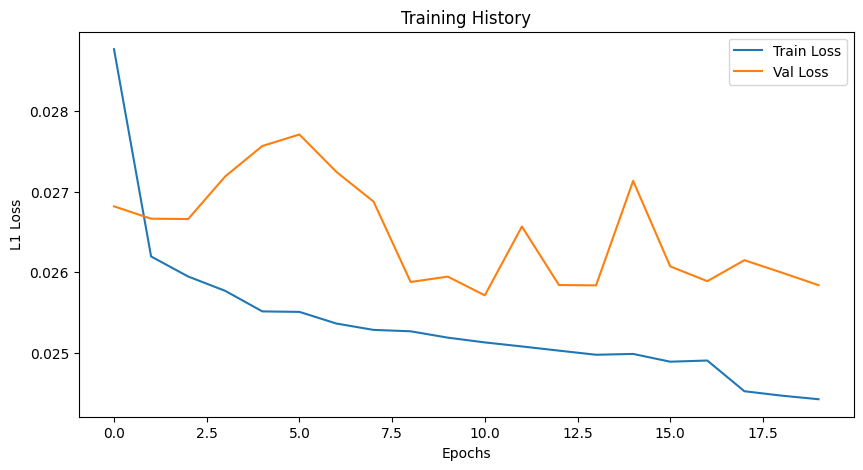

In [17]:
# Plot History
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.title('Training History')
plt.show()

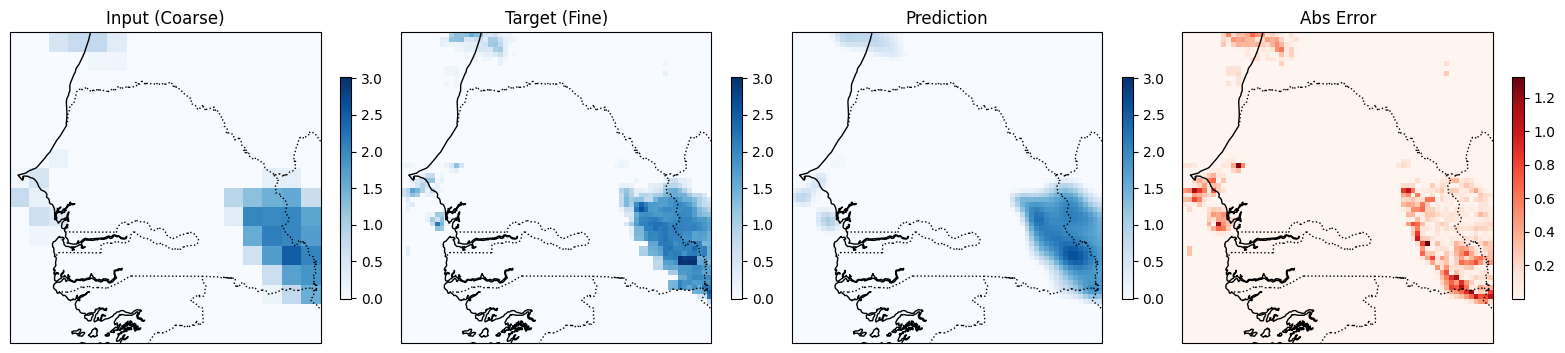

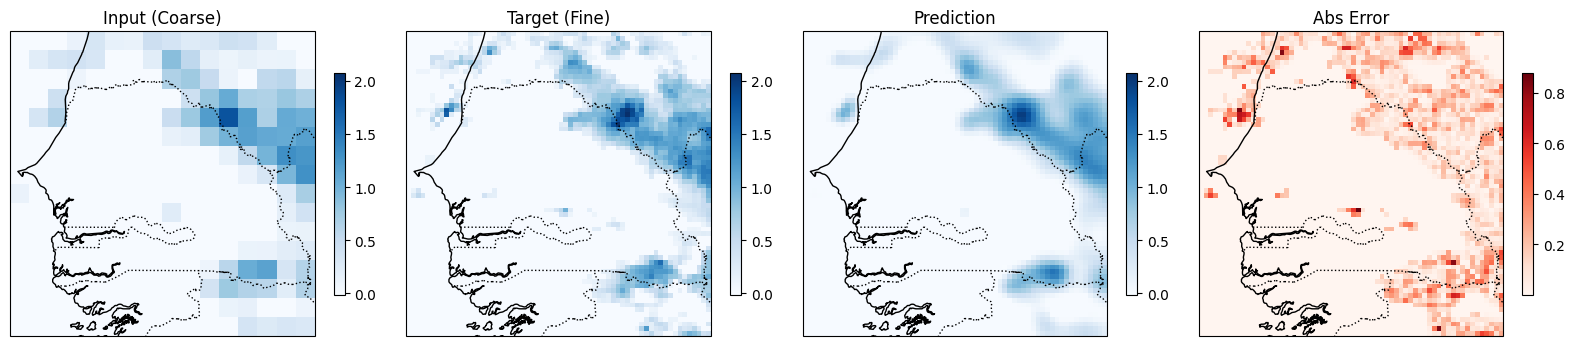

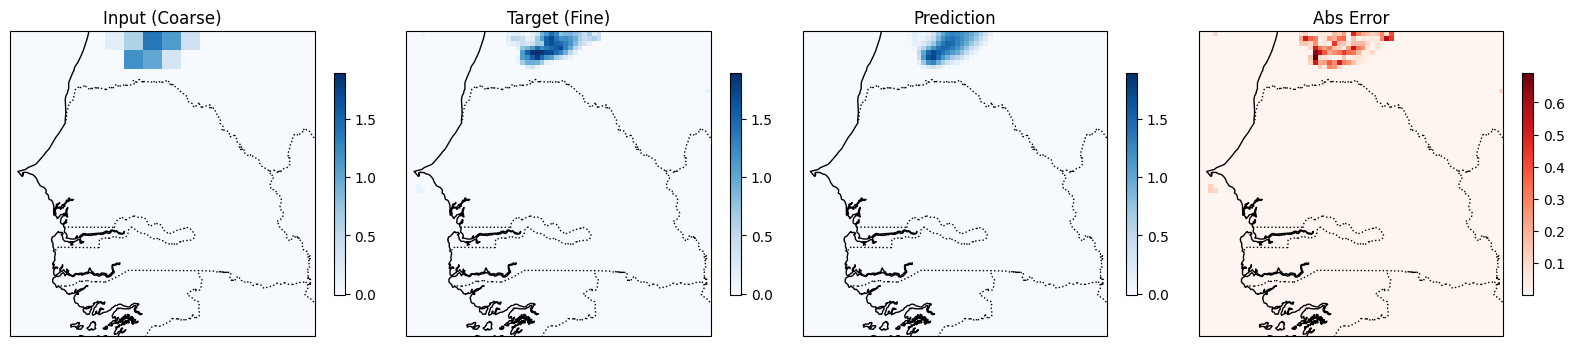

In [18]:
# Load Best Model
model.load_state_dict(torch.load('best_unet.pth'))
model.eval()

# Pick random test samples
indices = np.random.choice(len(test_dataset), 3, replace=False)

for idx in indices:
    x, y = test_dataset[idx]
    x_in = x.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x_in).cpu().squeeze().numpy()

    x_np = x.squeeze().numpy()
    y_np = y.squeeze().numpy()

    fig = plt.figure(figsize=(16, 4))

    # Compute common vmin/vmax for Input, Target, Prediction
    vmin = min(x_np.min(), y_np.min(), pred.min())
    vmax = max(x_np.max(), y_np.max(), pred.max())

    # Input
    ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
    ax1.set_title("Input (Coarse)")
    im1 = ax1.pcolormesh(lon_coarse, lat_coarse, x_np, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im1, ax=ax1, shrink=0.6)

    # Target
    ax2 = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
    ax2.set_title("Target (Fine)")
    im2 = ax2.pcolormesh(lon_fine, lat_fine, y_np, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im2, ax=ax2, shrink=0.6)

    # Prediction
    ax3 = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
    ax3.set_title("Prediction")
    im3 = ax3.pcolormesh(lon_fine, lat_fine, pred, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax3.add_feature(cfeature.COASTLINE)
    ax3.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im3, ax=ax3, shrink=0.6)

    # Error
    ax4 = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
    ax4.set_title("Abs Error")
    im4 = ax4.pcolormesh(lon_fine, lat_fine, np.abs(y_np - pred), cmap='Reds', shading='nearest', transform=ccrs.PlateCarree())
    ax4.add_feature(cfeature.COASTLINE)
    ax4.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im4, ax=ax4, shrink=0.6)

    plt.tight_layout()
    plt.show()

The results show that the U-Net model is able to reconstruct
fine scale spatial patterns that are absent in the low-resolution input.
The predicted fields are spatially smoother than the reference,
which is a known limitation of MSE based training in regression tasks.